In [9]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from itertools import combinations


from multiprocessing import Pool
def cal(p_id, X, y, comb_list):
    accs = []
    cvs = []
    combs = []
    for index, comb in enumerate(comb_list):
        if(index % 400 == 0): print(f"\t{p_id} {index}/{len(comb_list)}")
        X,y = getXY(csv.copy(),features=features[list(comb)] , do_print=False)
        model_all, acc, cross = train_model(X,y, do_print=False)
        accs.append(acc)
        cvs.append(cross.mean())
        combs.append(comb)
    return combs,accs,cvs   


csv = pd.read_csv('export/15s_133features_filter_std.csv')
print(f"{csv.shape=}")

def getXY(csv, features=None, do_print=True):
    df = csv.copy()
    y_ori = np.array(df['type'])
    y_ori[y_ori == 0] = 0
    y_ori[y_ori == 2] = 1
    y_ori
    if(type(features) == type(None)):
        head = list(df.keys())
        head.remove('Unnamed: 0')
        head.remove('name')
        head.remove('score')
        head.remove('type')
        X_ori = np.array(df[head])
    else:
        X_ori = np.array(df[features])
    if(do_print):
        print(f"{X_ori.shape=} {y_ori.shape=}")
    return X_ori, y_ori

csv.shape=(720, 137)


In [2]:
def train_model(X_ori,y_ori, do_print=True):
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel='rbf')
    cross = cross_val_score(model, X_shuff, y_shuff, cv=10)

    model = SVC(kernel='rbf')
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    if(do_print):
        print(acc, cross.mean(), cross)
        return model
    else:
        return model, acc, cross

def report(names,labels,predicts,do_print = True):
    correct = 0
    wrong = 0
    prev_name = None
    prev_label = None
    count = 0

    table = []
    summary = []
    wrong3of4 = 0
    table.append(f"Name\tLabel\tPredict")
    table.append("="*30)
    for name,predict,label in zip(names,predicts,labels):
        if(predict == label): correct += 1
        else: wrong += 1

        text_predict = 'non-st' if predict == 0 else 'stress'
        text_label = 'non-st' if label == 0 else 'stress'
        if(prev_name != None and prev_name != name and count > 0): 
            text_prev_label = 'non-st' if prev_label == 0 else 'stress'
            summary.append(f"label={text_prev_label} | {count} {prev_name}")
            if(count > 5): wrong3of4 += 1
            count = 0
        if(predict != label):
            count = count + 1
            table.append(f"{name}\t{text_label}\t{text_predict}")

        prev_label = label
        prev_name = name
        
    if(do_print):
        print('\n'.join(table))    
        print()
        print("Incorrect summany")
        print("="*30)
        print('\n'.join(summary))
        print(f"Correct={correct} | Wrong={wrong} | Acc={correct / (correct + wrong) * 100}%")
    else:
        acc = correct / (correct + wrong)
        return summary, acc, wrong3of4

In [3]:
features = np.array(['Fp1_Delta',
'F3_Delta',
'F4_Delta',
'C3_Delta',
'P4_Delta',
'F3_Theta',
'C3_Theta',
'T4_Theta',
'P4_Theta',
'F3_Alpha',
'F4_Alpha',
'F7_Alpha',
'T6_Alpha',
'P4_Alpha',
'F3_Beta',
'F3_Gamma',
'T3_Gamma',
'F3_Slow',
'F3_Low_beta',
'T4_Low_beta',
'C3_relative_gamma',
'alpha_frontal',
'alpha_temporal',
'alpha_asymmetry',
'beta_frontal'])

In [4]:
# model_all
X,y = getXY(csv.copy(),features=features)
model_all = train_model(X,y)

samples,labels = getXY(csv.copy(),features=features)
names = csv['name']
predicts = model_all.predict(samples) 
print()
report(names,labels,predicts)

X_ori.shape=(720, 25) y_ori.shape=(720,)
0.9875 0.9791666666666667 [1.         0.98611111 0.95833333 0.97222222 0.97222222 0.95833333
 0.95833333 1.         0.98611111 1.        ]
X_ori.shape=(720, 25) y_ori.shape=(720,)

Name	Label	Predict
flm	stress	non-st
flm	stress	non-st
flm	stress	non-st
minkhant	stress	non-st
nisit	non-st	stress
pla	stress	non-st
ploy	stress	non-st
prin	non-st	stress
prin	non-st	stress

Incorrect summany
label=stress | 3 flm
label=stress | 1 minkhant
label=non-st | 1 nisit
label=stress | 1 pla
label=stress | 1 ploy
label=non-st | 2 prin
Correct=711 | Wrong=9 | Acc=98.75%


# Feature Important

In [5]:
accs = []
cvs = []
for f_index in range(len(features)):
    X,y = getXY(csv.copy(),features=features[[f_index]] , do_print=False)
    model_all, acc, cross = train_model(X,y, do_print=False)

    # print(f"index:{f_index}|name:{features[f_index]}|mean:{round(acc*100,2)}|10-cv:{round(cross.mean()*100,2)} ")
    accs.append(acc)
    cvs.append(cross.mean())
print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[index]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


Summary -- Number:25 Average Acc:62.37 Average 10-folds CV: 61.93
Top 10
Feature:beta_frontal|Acc:69.44|10-cv:69.31
Feature:F3_Delta|Acc:68.75|10-cv:68.75
Feature:F3_Gamma|Acc:68.06|10-cv:68.33
Feature:F3_Theta|Acc:66.94|10-cv:67.08
Feature:T6_Alpha|Acc:65.56|10-cv:64.72
Feature:T4_Theta|Acc:64.17|10-cv:63.61
Feature:P4_Alpha|Acc:63.89|10-cv:63.61
Feature:C3_Delta|Acc:63.33|10-cv:63.19
Feature:T4_Low_beta|Acc:63.06|10-cv:63.06
Feature:Fp1_Delta|Acc:63.06|10-cv:62.36


In [30]:
# combinations( range(len(features)) , 2 )

accs = []
cvs = []
combs = []
for comb in combinations( range(len(features)) , 2 ):
    # print(comb)
    X,y = getXY(csv.copy(),features=features[list(comb)] , do_print=False)
    model_all, acc, cross = train_model(X,y, do_print=False)
    accs.append(acc)
    cvs.append(cross.mean())
    combs.append(comb)
print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


Summary -- Number:300 Average Acc:70.35 Average 10-folds CV: 68.97
Top 10
Feature:['F3_Delta' 'F3_Gamma']|Acc:77.92|10-cv:76.11
Feature:['F3_Delta' 'T6_Alpha']|Acc:77.5|10-cv:75.28
Feature:['F3_Gamma' 'beta_frontal']|Acc:77.5|10-cv:77.5
Feature:['F3_Delta' 'beta_frontal']|Acc:77.22|10-cv:76.81
Feature:['F3_Delta' 'T4_Theta']|Acc:76.81|10-cv:76.39
Feature:['P4_Alpha' 'F3_Gamma']|Acc:76.81|10-cv:74.03
Feature:['F3_Delta' 'C3_Theta']|Acc:76.67|10-cv:75.69
Feature:['F3_Delta' 'F3_Beta']|Acc:76.67|10-cv:76.11
Feature:['F3_Delta' 'P4_Delta']|Acc:76.53|10-cv:75.42
Feature:['T4_Theta' 'F3_Gamma']|Acc:76.39|10-cv:75.0


In [38]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,3 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    for p_id in range(6):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::6]] ))
    for i in range(6):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


	0 0/384	1 0/384	2 0/383	3 0/383	5 0/383	4 0/383





========= close ========
Summary -- Number:2300 Average Acc:76.59 Average 10-folds CV: 74.72
Top 10
Feature:['F3_Delta' 'P4_Delta' 'P4_Alpha']|Acc:86.25|10-cv:85.83
Feature:['F3_Delta' 'P4_Delta' 'T3_Gamma']|Acc:85.69|10-cv:83.75
Feature:['P4_Theta' 'P4_Alpha' 'F3_Beta']|Acc:85.42|10-cv:83.89
Feature:['F3_Delta' 'P4_Delta' 'T6_Alpha']|Acc:85.14|10-cv:83.47
Feature:['F3_Delta' 'P4_Delta' 'C3_Theta']|Acc:84.86|10-cv:83.33
Feature:['F3_Delta' 'P4_Theta' 'P4_Alpha']|Acc:84.72|10-cv:83.19
Feature:['T4_Theta' 'F7_Alpha' 'F3_Beta']|Acc:84.58|10-cv:80.14
Feature:['C3_Delta' 'T4_Theta' 'F3_Gamma']|Acc:84.44|10-cv:82.78
Feature:['F3_Delta' 'T3_Gamma' 'T4_Low_beta']|Acc:84.44|10-cv:82.78
Feature:['P4_Delta' 'T3_Gamma' 'T4_Low_beta']|Acc:84.31|10-cv:82.22


In [40]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,4 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    num_p = 8
    for p_id in range(num_p):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::num_p]] ))
    for i in range(num_p):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


	1 0/1582	0 0/1582	3 0/1581	2 0/1581	5 0/1581	6 0/1581
	4 0/1581


	7 0/1581



	0 400/1582
	4 400/1581
	1 400/1582
	3 400/1581
	5 400/1581
	6 400/1581
	7 400/1581
	2 400/1581
	0 800/1582
	6 800/1581
	4 800/1581
	1 800/1582
	2 800/1581
	5 800/1581
	3 800/1581
	7 800/1581
	0 1200/1582
	7 1200/1581
	3 1200/1581
	6 1200/1581
	2 1200/1581
	5 1200/1581
	4 1200/1581
	1 1200/1582
========= close ========
Summary -- Number:12650 Average Acc:81.46 Average 10-folds CV: 79.31
Top 10
Feature:['F3_Delta' 'P4_Delta' 'T3_Gamma' 'T4_Low_beta']|Acc:91.81|10-cv:90.28
Feature:['F3_Delta' 'P4_Delta' 'P4_Alpha' 'T3_Gamma']|Acc:91.11|10-cv:89.44
Feature:['F4_Delta' 'P4_Theta' 'P4_Alpha' 'T3_Gamma']|Acc:91.11|10-cv:89.17
Feature:['F3_Delta' 'P4_Delta' 'C3_Theta' 'P4_Alpha']|Acc:90.83|10-cv:89.58
Feature:['P4_Theta' 'F3_Gamma' 'T4_Low_beta' 'C3_relative_gamma']|Acc:90.83|10-cv:88.75
Feature:['P4_Delta' 'F3_Theta' 'C3_Theta' 'P4_Alpha']|Acc:90.69|10-cv:88.47
Feature:['P4_Theta' 'F3_Beta' 'T4_Low_beta' 'C3_rela

In [41]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,5 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    num_p = 8
    for p_id in range(num_p):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::num_p]] ))
    for i in range(num_p):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


	0 0/6642	2 0/6641	1 0/6642


	3 0/6641	4 0/6641
	5 0/6641
	6 0/6641	7 0/6641


	7 400/6641
	1 400/6642
	4 400/6641
	5 400/6641
	2 400/6641
	6 400/6641
	0 400/6642
	3 400/6641
	7 800/6641
	2 800/6641
	5 800/6641
	3 800/6641
	4 800/6641
	1 800/6642
	6 800/6641
	0 800/6642
	7 1200/6641
	2 1200/6641
	5 1200/6641
	1 1200/6642
	3 1200/6641
	4 1200/6641
	0 1200/6642
	6 1200/6641
	7 1600/6641
	1 1600/6642
	3 1600/6641
	4 1600/6641
	5 1600/6641
	2 1600/6641
	0 1600/6642
	6 1600/6641
	7 2000/6641
	1 2000/6642
	2 2000/6641
	0 2000/6642
	3 2000/6641
	4 2000/6641
	5 2000/6641
	6 2000/6641
	7 2400/6641
	2 2400/6641
	4 2400/6641
	3 2400/6641
	0 2400/6642
	1 2400/6642
	6 2400/6641
	5 2400/6641
	7 2800/6641
	3 2800/6641
	2 2800/6641
	0 2800/6642
	4 2800/6641
	1 2800/6642
	5 2800/6641
	6 2800/6641
	7 3200/6641
	4 3200/6641
	3 3200/6641
	0 3200/6642
	5 3200/6641
	2 3200/6641
	1 3200/6642
	6 3200/6641
	7 3600/6641
	4 3600/6641
	3 3600/6641
	5 3600/6641
	0 3600/6642
	2 3600/6641
	1 3600/6642
	6 3600/6641


In [42]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,6 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    num_p = 8
    for p_id in range(num_p):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::num_p]] ))
    for i in range(num_p):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


	0 0/22138
	1 0/22138
	2 0/22138
	3 0/22138
	4 0/22137
	5 0/22137
	7 0/22137	6 0/22137

	1 400/22138
	0 400/22138
	6 400/22137
	3 400/22138
	7 400/22137
	2 400/22138
	4 400/22137
	5 400/22137
	0 800/22138
	6 800/22137
	1 800/22138
	7 800/22137
	2 800/22138
	3 800/22138
	5 800/22137
	4 800/22137
	0 1200/22138
	1 1200/22138
	4 1200/22137
	6 1200/22137
	2 1200/22138
	7 1200/22137
	3 1200/22138
	5 1200/22137
	1 1600/22138
	0 1600/22138
	6 1600/22137
	4 1600/22137
	2 1600/22138
	3 1600/22138
	7 1600/22137
	5 1600/22137
	0 2000/22138
	2 2000/22138
	1 2000/22138
	5 2000/22137
	3 2000/22138
	6 2000/22137
	4 2000/22137
	7 2000/22137
	0 2400/22138
	2 2400/22138
	6 2400/22137
	3 2400/22138
	5 2400/22137
	1 2400/22138
	4 2400/22137
	7 2400/22137
	0 2800/22138
	5 2800/22137
	6 2800/22137
	2 2800/22138
	3 2800/22138
	4 2800/22137
	7 2800/22137
	1 2800/22138
	0 3200/22138
	2 3200/22138
	5 3200/22137
	4 3200/22137
	3 3200/22138
	6 3200/22137
	7 3200/22137
	1 3200/22138
	0 3600/22138
	5 3600/22137
	2 3

In [12]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,7 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    num_p = 14
    for p_id in range(num_p):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::num_p]] ))
    for i in range(num_p):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


	0 0/34336
	1 0/34336
	2 0/34336
	3 0/34336
	4 0/34336
	5 0/34336
	6 0/34336
	7 0/34336
	8 0/34336
	9 0/34336
	10 0/34335
	11 0/34335
	12 0/34335
	13 0/34335
	1 400/34336
	6 400/34336
	7 400/34336
	2 400/34336
	0 400/34336
	13 400/34335
	8 400/34336
	3 400/34336
	11 400/34335
	5 400/34336
	9 400/34336
	12 400/34335
	4 400/34336
	10 400/34335
	6 800/34336
	7 800/34336
	1 800/34336
	2 800/34336
	3 800/34336
	13 800/34335
	0 800/34336
	9 800/34336
	8 800/34336
	4 800/34336
	5 800/34336
	12 800/34335
	11 800/34335
	10 800/34335
	6 1200/34336
	7 1200/34336
	1 1200/34336
	2 1200/34336
	13 1200/34335
	0 1200/34336
	3 1200/34336
	8 1200/34336
	9 1200/34336
	11 1200/34335
	4 1200/34336
	5 1200/34336
	10 1200/34335
	12 1200/34335
	6 1600/34336
	7 1600/34336
	2 1600/34336
	1 1600/34336
	13 1600/34335
	0 1600/34336
	3 1600/34336
	8 1600/34336
	9 1600/34336
	11 1600/34335
	5 1600/34336
	4 1600/34336
	12 1600/34335
	10 1600/34335
	6 2000/34336
	7 2000/34336
	13 2000/34335
	1 2000/34336
	0 2000/34336

KeyboardInterrupt: 

In [ ]:
accs = []
cvs = []
combs = []
comb_list = list(combinations( range(len(features)) ,8 ))
try:
    t_out = 60000
    pool = Pool()
    p_list = []
    num_p = 8
    for p_id in range(num_p):
        p_list.append(pool.apply_async( cal, [p_id, X,y,comb_list[p_id::num_p]] ))
    for i in range(num_p):
        ans = p_list[i].get(timeout=t_out)
        combs = combs + ans[0]
        accs = accs + ans[1]
        cvs = cvs + ans[2]
    # ans_list
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()


print(f"Summary -- Number:{len(accs)} Average Acc:{round(np.array(accs).mean()*100,2)} Average 10-folds CV: {round(np.array(cvs).mean()*100,2)}")

accs, cvs = np.array(accs), np.array(cvs)
top_10_indexes = accs.argsort()[::-1][:10]
print(f"Top 10")
print("="*10)
for index in top_10_indexes:
    print(f"Feature:{features[list(combs[index])]}|Acc:{round(accs[index]*100,2)}|10-cv:{round(cvs[index]*100,2)}")


In [27]:
X,y = getXY(csv.copy(),features=features , do_print=False)
corrMatrix = csv[features].corr()

In [ ]:
'F3_Delta' 'P4_Delta' 'T3_Gamma' 'T4_Low_beta'

In [44]:
corrMatrix['F3_Delta'].sort_values()

alpha_frontal        0.002013
P4_Alpha             0.066880
C3_relative_gamma    0.082069
beta_frontal         0.087326
alpha_asymmetry      0.133266
alpha_temporal       0.179980
T6_Alpha             0.182012
T4_Theta             0.216826
C3_Delta             0.278066
T3_Gamma             0.278134
F7_Alpha             0.280360
T4_Low_beta          0.297339
C3_Theta             0.308029
P4_Theta             0.347724
F4_Alpha             0.436964
P4_Delta             0.439373
F3_Alpha             0.440007
F3_Gamma             0.495514
Fp1_Delta            0.528032
F3_Beta              0.600747
F4_Delta             0.604241
F3_Low_beta          0.639497
F3_Slow              0.674743
F3_Theta             0.858991
F3_Delta             1.000000
Name: F3_Delta, dtype: float64

In [46]:
features.shape

(25,)

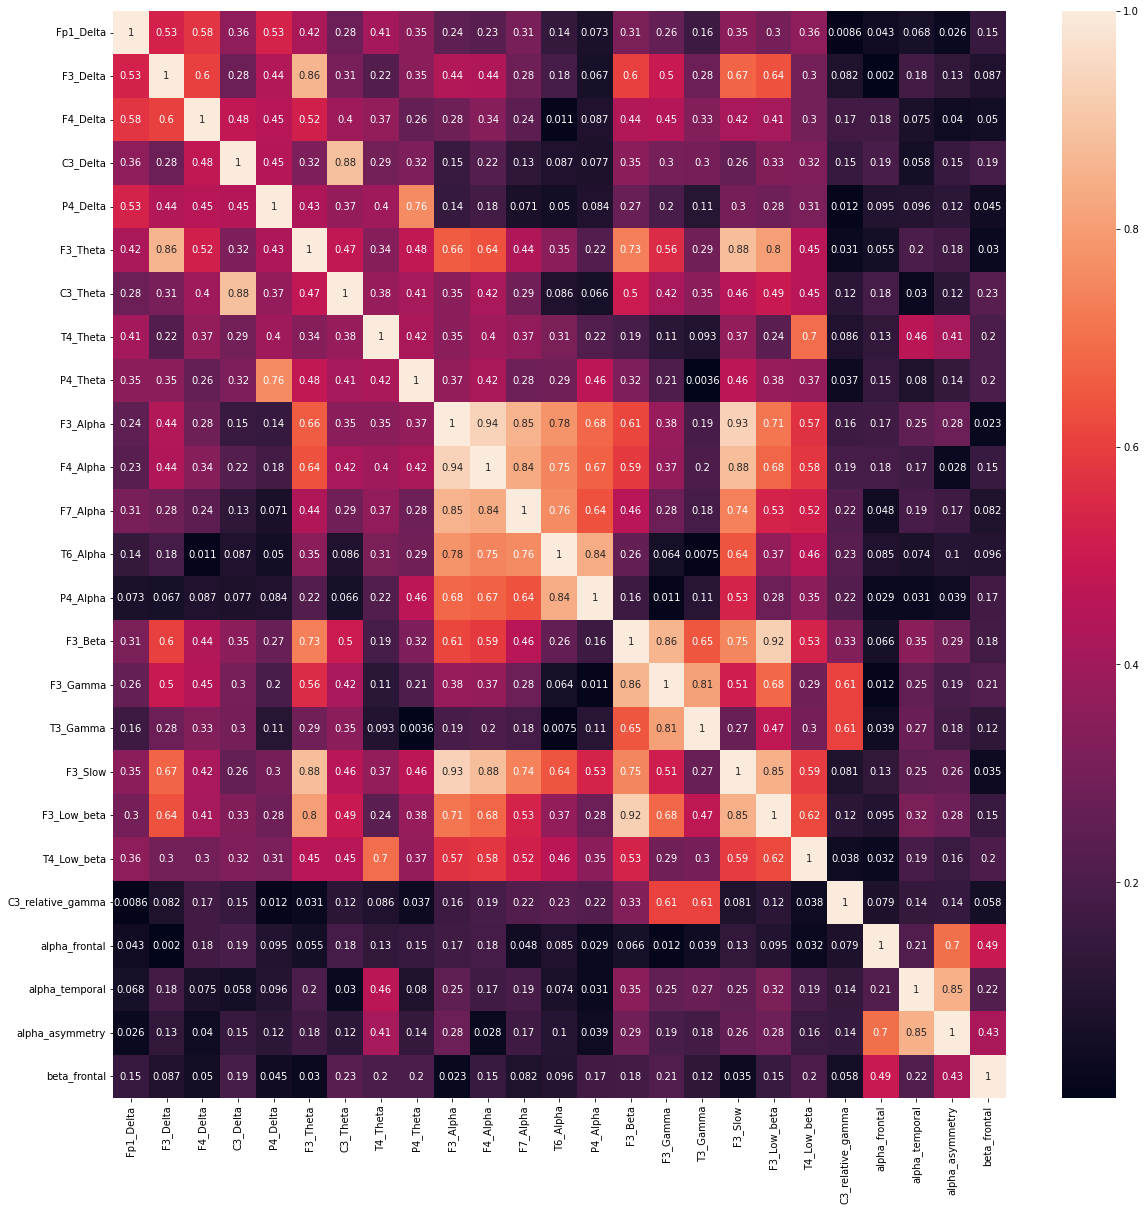

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
sn.heatmap(abs(corrMatrix), annot=True)
plt.show()